### refer : https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, )
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir='../../')

In [4]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
PATH, train_dir, validation_dir

('../../datasets/cats_and_dogs_filtered',
 '../../datasets/cats_and_dogs_filtered/train',
 '../../datasets/cats_and_dogs_filtered/validation')

In [5]:
# train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
# train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
# validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# num_cats_tr = len(os.listdir(train_cats_dir))
# num_dogs_tr = len(os.listdir(train_dogs_dir))

# num_cats_val = len(os.listdir(validation_cats_dir))
# num_dogs_val = len(os.listdir(validation_dogs_dir))

# total_train = num_cats_tr + num_dogs_tr
# total_val = num_cats_val + num_dogs_val
batch_size = 128
IMG_HEIGHT = 160
IMG_WIDTH = 160
# WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

In [6]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest') # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
sample_training_images, _ = next(train_data_gen)
sample_training_images.shape

(128, 160, 160, 3)

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH ,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

2022-01-25 17:05:54.160079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-25 17:05:54.160615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# len(model.trainable_variables)
# model.summary()

In [13]:
initial_epochs = 20

hist = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

2022-01-25 17:05:55.763411: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-01-25 17:05:56.381015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.8101 - accuracy: 0.4970

2022-01-25 17:06:05.994832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 13s 671ms/step - loss: 0.8101 - accuracy: 0.4970 - val_loss: 0.7350 - val_accuracy: 0.5150
Epoch 2/20
16/16 [==============================] - 10s 641ms/step - loss: 0.7176 - accuracy: 0.5430 - val_loss: 0.6404 - val_accuracy: 0.5780
Epoch 3/20
16/16 [==============================] - 10s 590ms/step - loss: 0.6612 - accuracy: 0.5985 - val_loss: 0.5631 - val_accuracy: 0.6480
Epoch 4/20
16/16 [==============================] - 10s 591ms/step - loss: 0.5858 - accuracy: 0.6525 - val_loss: 0.5036 - val_accuracy: 0.7180
Epoch 5/20
16/16 [==============================] - 10s 591ms/step - loss: 0.5588 - accuracy: 0.6770 - val_loss: 0.4556 - val_accuracy: 0.7590
Epoch 6/20
16/16 [==============================] - 10s 591ms/step - loss: 0.5250 - accuracy: 0.6925 - val_loss: 0.4170 - val_accuracy: 0.7910
Epoch 7/20
16/16 [==============================] - 10s 591ms/step - loss: 0.4718 - accuracy: 0.7335 - val_loss: 0.3859 - val_accuracy: 0.8180
Epoch 8/20

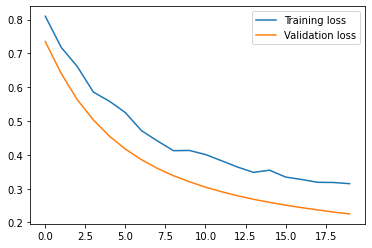

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.epoch, hist.history['loss'], label='Training loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

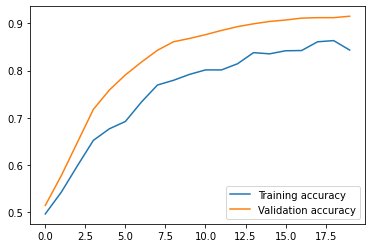

In [15]:
plt.plot(hist.epoch, hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

### fineTuning

In [20]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [21]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10, momentum=0.9),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 20

hist = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/20


2022-01-25 17:16:47.280737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9375

2022-01-25 17:16:55.893276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 12s 662ms/step - loss: 0.1552 - accuracy: 0.9375 - val_loss: 0.1004 - val_accuracy: 0.9700
Epoch 2/20
16/16 [==============================] - 10s 621ms/step - loss: 0.1444 - accuracy: 0.9365 - val_loss: 0.0878 - val_accuracy: 0.9700
Epoch 3/20
16/16 [==============================] - 10s 619ms/step - loss: 0.1146 - accuracy: 0.9540 - val_loss: 0.0780 - val_accuracy: 0.9730
Epoch 4/20
16/16 [==============================] - 10s 616ms/step - loss: 0.1164 - accuracy: 0.9555 - val_loss: 0.0814 - val_accuracy: 0.9740
Epoch 5/20
16/16 [==============================] - 10s 617ms/step - loss: 0.1189 - accuracy: 0.9495 - val_loss: 0.0745 - val_accuracy: 0.9740
Epoch 6/20
16/16 [==============================] - 10s 615ms/step - loss: 0.1097 - accuracy: 0.9530 - val_loss: 0.0742 - val_accuracy: 0.9760
Epoch 7/20
16/16 [==============================] - 10s 617ms/step - loss: 0.1124 - accuracy: 0.9525 - val_loss: 0.0688 - val_accuracy: 0.9770
Epoch 8/20

In [18]:
# None FineTuning - loss: 0.3148 - accuracy: 0.8435 - val_loss: 0.2253 - val_accuracy: 0.9150
# tf.keras.optimizers.SGD - 11s 670ms/step - loss: 0.1833 - accuracy: 0.9280 - val_loss: 0.1300 - val_accuracy: 0.9660
# tf.keras.optimizers.Adam - 11s 664ms/step - loss: 0.0510 - accuracy: 0.9800 - val_loss: 0.0685 - val_accuracy: 0.9790
model.save('./model_finetuning_MobileNetV2.h5')

/Users/sanghunoh/miniforge3/envs/ml_p3.9_tf2.7/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
